<a href="https://colab.research.google.com/github/yunju-1118/ESAA/blob/main/ESAA_YB_week13_2_clustering(3).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **DBSCAN**

### **DBSCAN 개요**

DBSCAN은 밀도 기반 군집화의 대표적인 알고리즘으로 간단하고 직관적인 알고리즘으로 되어있음에도 데이터의 분포가 기하학적으로 복잡한 데이터 세트에도 효과적인 군집화가 가능하다.


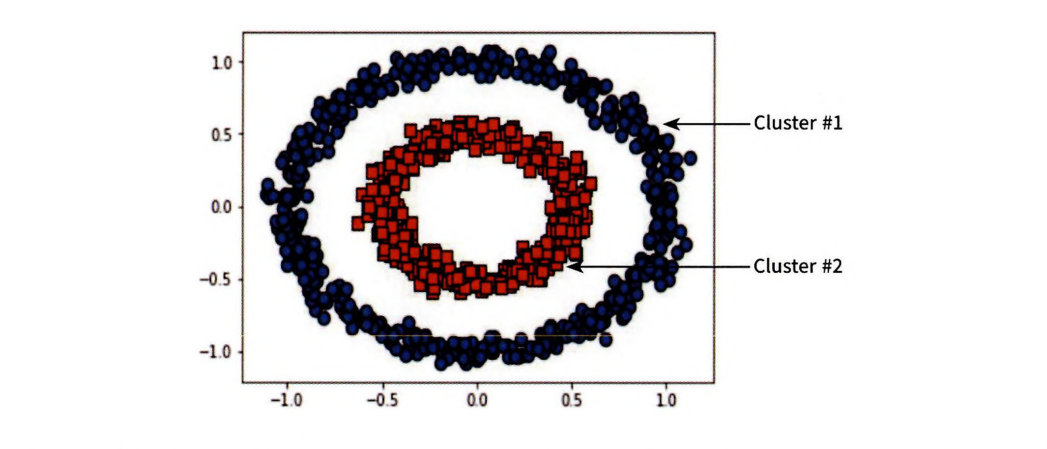

DBSCAN을 구성하는 중요한 파라미터는 다음과 같다.
- **epsilon**: 개별 데이터를 중심으로 입실론 반경을 가지는 원형의 영역
- **min points**: 개별 데이터의 입실론 주변 영역에 포함되는 타 데이터의 개수

입실론 주변 영역 내에 포함되는 최소 데이터 개수를 충족시키는가 아닌가에 따라 데이터 포인트를 다음과 같이 정의한다.
- **Core Point**: 주변 영역 내에 최소 데이터 개수 이상의 타 데이터를 가지고 있을 경우 해당 데이터를 **핵심 포인트**라고 한다.
- **Neighbor Point**: 주변 영역 내에 위치한 타 데이터를 **이웃 포인트**라고 한다.
- **Border Point**: 최소 데이터 개수 이상의 이웃 포인트를 가지고 있지 않지만 핵심 포인트를 이웃 포인트로 가지고 있는 데이터를 **경계 포인트**라고 한다.
- **Noise Point**: 최소 데이터 개수 이상의 이웃 포인트를 가지고 있지 않으며 핵심 포인트도 이웃 포인트로 가지고 있지 않은 데이터를 **잡음 포인트**라고 한다.

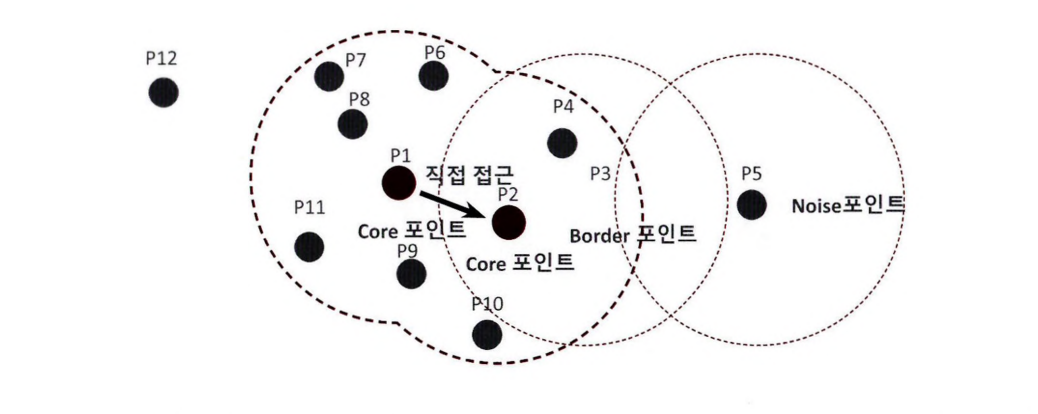

사이킷런은 DBSCAN 클래스를 통해 DBSCAN 알고리즘을 지원한다. DBSCAN 클래스는 다음과 같은 초기화 파라미터를 가지고 있다.
- **eps**: 입실론 주변 영역의 반경을 의미한다.
- **min_samples**: 핵심 포인트가 되기 위해 입실론 주변 영역 내에 포함되어야 할 데이터의 최소 개수를 의미한다. (자신의 데이터 포함)

### **DBSCAN 적용하기 - iris 데이터 세트**

In [1]:
from sklearn.datasets import load_iris
from sklearn.cluster import KMeans

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline

iris=load_iris()
feature_names=['sepal_length', 'sepal_width', 'petal_length', 'petal_width']

# 좀 더 편리한 데이터 Handling을 위해 DataFrame으로 변환
irisDF=pd.DataFrame(data=iris.data, columns=feature_names)
irisDF['target']=iris.target

DBSCAN을 이용해 붓꽃 데이터 세트를 군집화한다. eps=0.6, min_samples=8로 한다. 일반적으로 eps 값은 1 이하의 값을 설정한다.

In [4]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=0.6, min_samples=8, metric='euclidean')
dbscan_labels = dbscan.fit_predict(iris.data)

irisDF['dbscan_cluster'] = dbscan_labels
irisDF['target'] = iris.target

iris_result = irisDF.groupby(['target'])['dbscan_cluster'].value_counts()
print(iris_result)

target  dbscan_cluster
0        0                49
        -1                 1
1        1                46
        -1                 4
2        1                42
        -1                 8
Name: count, dtype: int64


위 결과에서 군집 레이블이 -1인 것은 노이즈에 속하는 군집을 의미한다. 따라서 위 붓꽃 데이터 세트는 DBSCAN에서 0과 1 두 개의 군집으로 군집화 되었다. DBSCAN은 군집의 개수를 알고리즘에 따라 자동으로 지정하므로 DBSCAN에서 군집의 개수를 지정하는 것은 무의미하다고 볼 수 있다.

DBSCAN으로 군집화한 데이터 세트를 2차원 평면에서 표현하기 위해 PCA를 통해 2개의 피처로 압축 변환한 뒤 시각화해보자.

In [5]:
def visualize_cluster_plot(clusterobj, dataframe, label_name, iscenter=True):
    if iscenter :
        centers = clusterobj.cluster_centers_

    unique_labels = np.unique(dataframe[label_name].values)
    markers=['o', 's', '^', 'x', '*']
    isNoise=False

    for label in unique_labels:
        label_cluster = dataframe[dataframe[label_name]==label]
        if label == -1:
            cluster_legend = 'Noise'
            isNoise=True
        else :
            cluster_legend = 'Cluster '+str(label)

        plt.scatter(x=label_cluster['ftr1'], y=label_cluster['ftr2'], s=70,
                    edgecolor='k', marker=markers[label], label=cluster_legend)

        if iscenter:
            center_x_y = centers[label]
            plt.scatter(x=center_x_y[0], y=center_x_y[1], s=250, color='white',
                        alpha=0.9, edgecolor='k', marker=markers[label])
            plt.scatter(x=center_x_y[0], y=center_x_y[1], s=70, color='k',
                        edgecolor='k', marker='' % label)
    if isNoise:
        legend_loc='upper center'
    else: legend_loc='upper right'

    plt.legend(loc=legend_loc)
    plt.show()

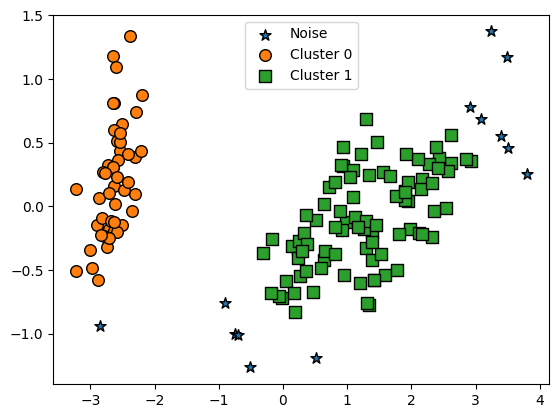

In [6]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2, random_state=0)
pca_transformed = pca.fit_transform(iris.data)
irisDF['ftr1'] = pca_transformed[:,0]
irisDF['ftr2'] = pca_transformed[:,1]

visualize_cluster_plot(dbscan, irisDF, 'dbscan_cluster', iscenter=False)

PCA로 2차원으로 표현하면 이상치인 노이즈 데이터가 명확히 드러난다. DBSCAN을 적용할 때는 특정 군집 개수로 군집을 강제하지 않는 것이 좋다. DBSCAN 알고리즘에 적절한 eps와 min_samples 파라미터를 통해 최적의 군집을 찾는 것이 중요하다. 일반적으로 eps를 크게 하면 반경이 커져 포함하는 데이터가 많아지므로 노이즈 데이터의 개수가 작아지고 min_samples를 크게 하면 더 많은 데이터를 포함시켜야 하므로 노이즈 데이터 개수가 커진다.

target  dbscan_cluster
0        0                50
1        1                50
2        1                47
        -1                 3
Name: count, dtype: int64


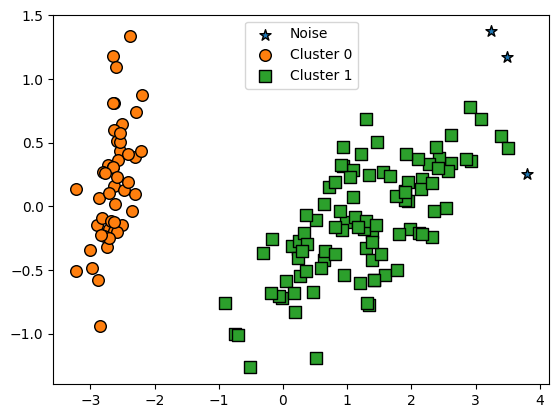

In [9]:
# eps 증가
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=0.8, min_samples=8, metric='euclidean')
dbscan_labels = dbscan.fit_predict(iris.data)

irisDF['dbscan_cluster'] = dbscan_labels
irisDF['target'] = iris.target

iris_result = irisDF.groupby(['target'])['dbscan_cluster'].value_counts()
print(iris_result)

visualize_cluster_plot(dbscan, irisDF, 'dbscan_cluster', iscenter=False)

target  dbscan_cluster
0        0                48
        -1                 2
1        1                44
        -1                 6
2        1                36
        -1                14
Name: count, dtype: int64


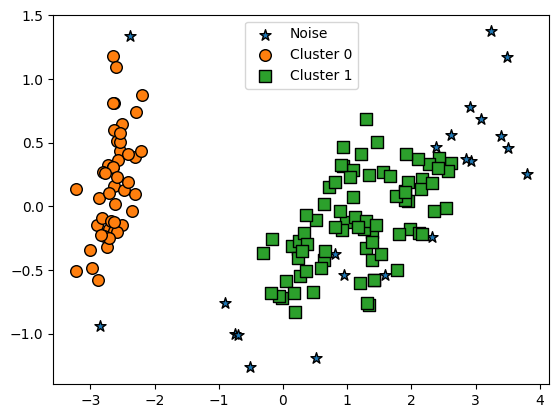

In [11]:
# min_samples 증가
dbscan = DBSCAN(eps=0.6, min_samples=16, metric='euclidean')
dbscan_labels = dbscan.fit_predict(iris.data)

irisDF['dbscan_cluster'] = dbscan_labels
irisDF['target'] = iris.target

iris_result = irisDF.groupby(['target'])['dbscan_cluster'].value_counts()
print(iris_result)

visualize_cluster_plot(dbscan, irisDF, 'dbscan_cluster', iscenter=False)

### **DBSCAN 적용하기 - make_circles( ) 데이터 세트**


make_circles( ) 함수를 이용해 내부 원과 외부 원 형태로 되어있는 2차원 데이터 세트를 만들어보자. 파라미터 noise는 노이즈 데이터 세트의 비율이며 factor는 외부 원과 내부 원의 scale 비율이다.

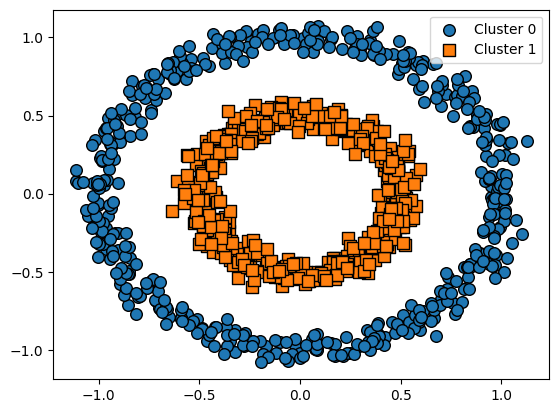

In [12]:
from sklearn.datasets import make_circles

X,y = make_circles(n_samples=1000, shuffle=True, noise=0.05, random_state=0, factor=0.5)
clusterDF = pd.DataFrame(data=X, columns=['ftr1', 'ftr2'])
clusterDF['target'] = y

visualize_cluster_plot(None, clusterDF, 'target', iscenter=False)

<ipython-input-5-3623408909>:24: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(x=center_x_y[0], y=center_x_y[1], s=70, color='k',


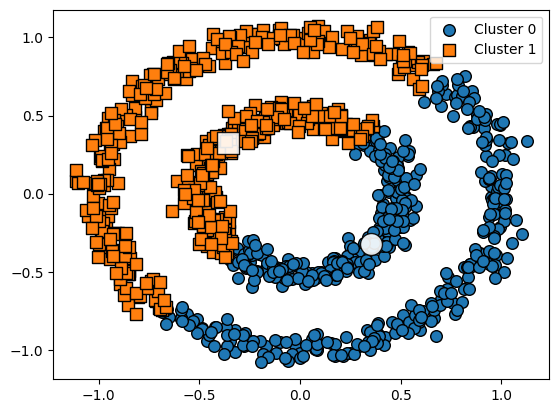

In [14]:
# KMeans로 make_circles( ) 데이터 세트를 군집화 수행
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=2, max_iter=1000, random_state=0)
kmeans_labels = kmeans.fit_predict(X)
clusterDF['kmeans_cluster'] = kmeans_labels

visualize_cluster_plot(kmeans, clusterDF, 'kmeans_cluster', iscenter=True)

거리 기반 군집화로는 데이터가 특정한 형태로 지속해서 이어지는 부분을 찾아내기 어렵다.

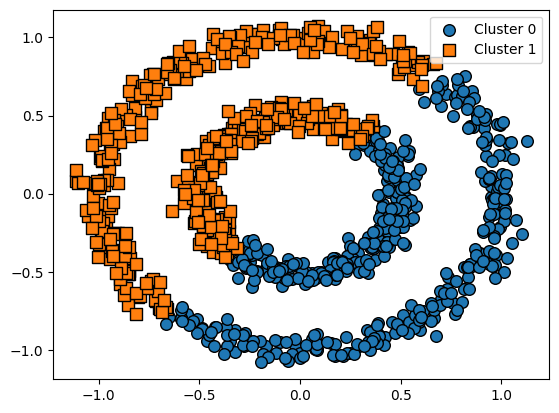

In [16]:
# GMM으로 make_circles( ) 데이터 세트를 군집화 수행
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=2, random_state=0)
gmm_label = gmm.fit(X).predict(X)
clusterDF['gmm_cluster'] = gmm_label

visualize_cluster_plot(gmm, clusterDF, 'gmm_cluster', iscenter=False)

GMM의 경우 일렬로 늘어선 데이터 세트에서는 효과적으로 군집화 적용이 가능했으나 내부와 외부의 원형으로 구성된 더 복잡한 형태에서는 군집화가 원하는 방향으로 되지 않는다.

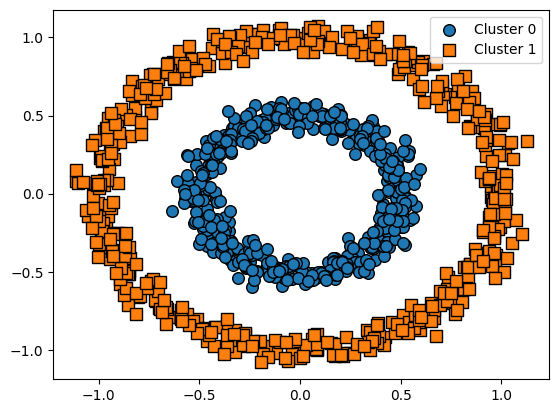

In [17]:
# DBSCAN으로 make_circles() 데이터 세트 군집화 수행
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=0.2, min_samples=10, metric='euclidean')
dbscan_labels = dbscan.fit_predict(X)
clusterDF['dbscan_cluster'] = dbscan_labels
visualize_cluster_plot(dbscan, clusterDF, 'dbscan_cluster', iscenter=False)

## **군집화 실습 - 고객 세그먼테이션**

### **고객 세그먼테이션의 정의와 기법**
고객 분류가 사용되는 대부분의 비즈니스가 상품 판매에 중점을 두고 있기 때문에 가장 중요한 분류 요소는 어떤 상품을 얼마나 많은 비용을 써서 얼마나 자주 사용하는가에 기반한 정보로 분류하는 것이다.

고객 세그먼테이션의 주요 목표는 타깃 마케팅이다. 타깃 마케팅이란 고객을 여러 특성에 맞게 세분화해 그 유형에 따라 맞춤형 마케팅이나 서비스를 제공하는 것이다.

고객 세그먼테이션은 고객의 어떤 요소를 기반으로 군집화할 것인가를 결정하는 것이 중요한데, 여기서는 기본적인 고객 분석 요소인 RFM 기법을 이용한다. RFM 기법은 Recency(R), Frequency(F), Monetary Value(M)의 각 앞글자를 합한 것으로서 각 단어의 의미는 다음과 같다.
- **Recency**: 가장 최근 상품 구입 일에서 오늘까지의 기간
- **Frequency**: 상품 구매 횟수
- **Monetary value**: 총 구매 금액

#### **데이터 세트 로딩과 데이터 클렌징**

In [18]:
import pandas as pd
import datetime
import math
import numpy as np
import matplotlib.pyplot as pit
%matplotlib inline
retail_df = pd.read_excel(io='Online Retail.xlsx')
retail_df.head(3)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom


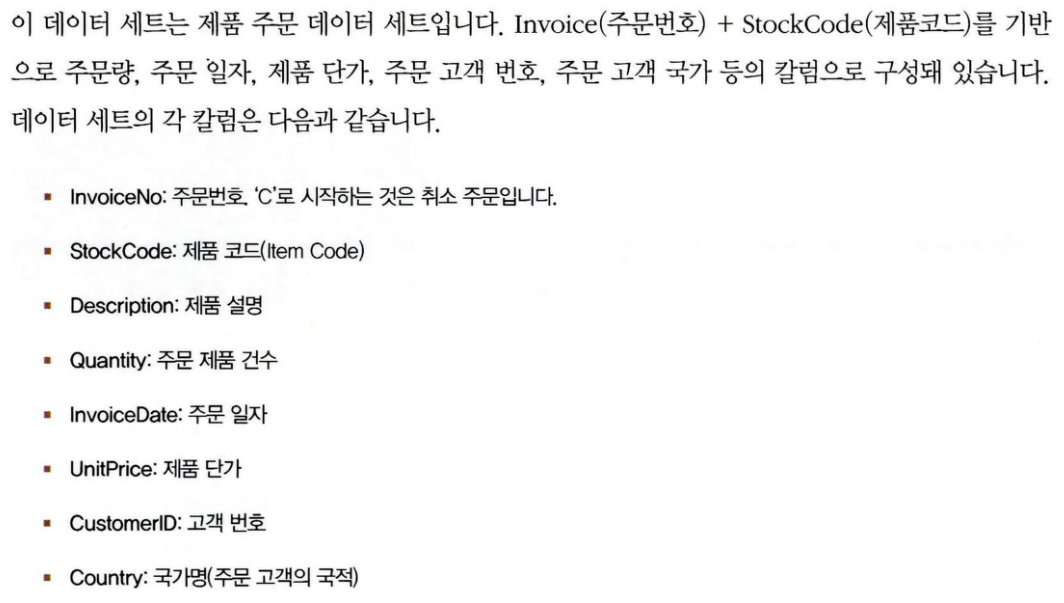

In [19]:
retail_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


전체 데이터는 541.909개로 CustomerID의 Null 값이 너무 많다. 그 외에 다른 칼럼의 경우도 오류 데이터가 존재한다. 따라서, 이 데이터 세트는 사전 정제 작업이 필요하다.

- **Null 데이터 제거**: 특히 CustomerID가 Null인 데이터가 많다. 고객 세그먼테이션에서는 고객 식별 번호가 없는 데이터는 필요 없기에 삭제한다.
- **오류 데이터 삭제**: 오류 데이터는 Quantity 또는 UnitPrice가 0보다 작은 경우이다. 분석의 효율성을 위해 이 데이터는 모두 삭제한다.

In [21]:
retail_df = retail_df[retail_df['Quantity']>0]
retail_df = retail_df[retail_df['UnitPrice']>0]
retail_df = retail_df[retail_df['CustomerID'].notnull()]
print(retail_df.shape)
retail_df.isnull().sum()

(397884, 8)


,0
InvoiceNo,0
StockCode,0
Description,0
Quantity,0
InvoiceDate,0
UnitPrice,0
CustomerID,0
Country,0


In [22]:
retail_df['Country'].value_counts()[:5]

,count
Country,
United Kingdom,354321
Germany,9040
France,8341
EIRE,7236
Spain,2484


주요 주문 고객은 대부분 UK이므로 UK를 제외한 다른 국가의 데이터는 모두 제외한다.

In [23]:
retail_df = retail_df[retail_df['Country']=='United Kingdom']
print(retail_df.shape)

(354321, 8)


#### **RFM 기반 데이터 가공**

In [24]:
retail_df['sale_amount'] = retail_df['Quantity']*retail_df['UnitPrice'] # 주문 금액
retail_df['CustomerID'] = retail_df['CustomerID'].astype(int)

In [25]:
# Top5 주문 건수와 주문 금액을 가진 고객 데이터 추출
print(retail_df['CustomerID'].value_counts().head(5))
print(retail_df.groupby('CustomerID')['sale_amount'].sum().sort_values(ascending=False)[:5])

CustomerID
17841    7847
14096    5111
12748    4595
14606    2700
15311    2379
Name: count, dtype: int64
CustomerID
18102    259657.30
17450    194550.79
16446    168472.50
17511     91062.38
16029     81024.84
Name: sale_amount, dtype: float64


온랑니 판매 데이터 세트는 주문번호 + 상품코드 레벨의 식별자로 되어있다. InvoiceNo + StockCode로 Groupby를 수행하면 거의 1에 가깝게 유일한 식별자 레벨이 됨을 알 수 있다.

In [26]:
retail_df.groupby(['InvoiceNo','StockCode'])['InvoiceNo'].count().mean()

np.float64(1.028702077315023)

RFM 기반의 고객 세그먼테이션을 위해 주문번호+상품코드 기준의 데이터를 고객 기준의 Recency, Frequency, Monetary value 데이터로 변경해야 한다. 이를 위해 groupby를 통해 CustomerID를 기준으로 DataFrame을 새롭게 생성한다. 또한 여러 개의 칼럼에 서로 다른 aggregation 연산을 하기 위해 반환된 DataFrameGroupby 객체에 agg( )를 이용한다.

**Frequency**는 고객별 주문 건수이므로 'CustomerID'로 groupby( )해서 'InvoiceNo'의 count( ) aggregation으로 구한다.

**Monetary**는 고객별 주문 금액이므로 'CustomerID'로 groupby( )해서 'sale_amount'의 sum( ) aggregation으로 구한다.

**Recency**의 경우 'CustomerID'로 groupby( )해서 'InvoiceData' 칼럼의 max( )로 고객별 가장 최근 주문 일자를 먼저 구한 뒤 추후에 가공 작업을 별도로 수행한다.

In [35]:
# DataFrame의 groupby()의 multiple 연산을 위해 agg() 이용
aggregations = {
    'InvoiceDate': 'max',
    'InvoiceNo': 'count',
    'sale_amount': 'sum'
}
cust_df = retail_df.groupby('CustomerID').agg(aggregations)
# groupby된 결과 칼럼 값을 Recency, Frequency, Monetary로 변경
cust_df = cust_df.rename(columns = {'InvoiceDate': 'Recency',
                                    'InvoiceNo': 'Frequency',
                                    'sale_amount': 'Monetary'})

cust_df = cust_df.reset_index()
cust_df.head(3)

,CustomerID,Recency,Frequency,Monetary
0,12346,2011-01-18 10:01:00,1,77183.60
1,12747,2011-12-07 14:34:00,103,4196.01
2,12748,2011-12-09 12:20:00,4595,33719.73


Recency 칼럼은 개별 고객당 가장 최근의 주문이므로 오늘 날짜를 기준으로 가장 최근 주문 일자를 빼야 한다. 여기서 주의할 점은 온랑니 판매 데이터가 2010년 12월 1일에서 2011년 12월 9일까지의 데이터이므로 오늘 날짜는 2011년 12월 9일에서 하루 더한 2011년 12월 10일로 한다.

In [36]:
import datetime as dt

cust_df['Recency'] = dt.datetime(2011,12,10) - cust_df['Recency']
cust_df['Recency'] =cust_df['Recency'].apply(lambda x: x.days+1)
print(cust_df.shape)
cust_df.head(3)

(3920, 4)


,CustomerID,Recency,Frequency,Monetary
0,12346,326,1,77183.60
1,12747,3,103,4196.01
2,12748,1,4595,33719.73


#### **RFM 기반 고객 세그먼테이션**

온라인 판매 데이터 세트는 소매업체의 대규모 주문을 포함한다. 따라서, 매우 왜곡된 데이터 분포도를 가지게 되어 군집화가 한쪽 군집에만 집중되는 현상이 발생한다.

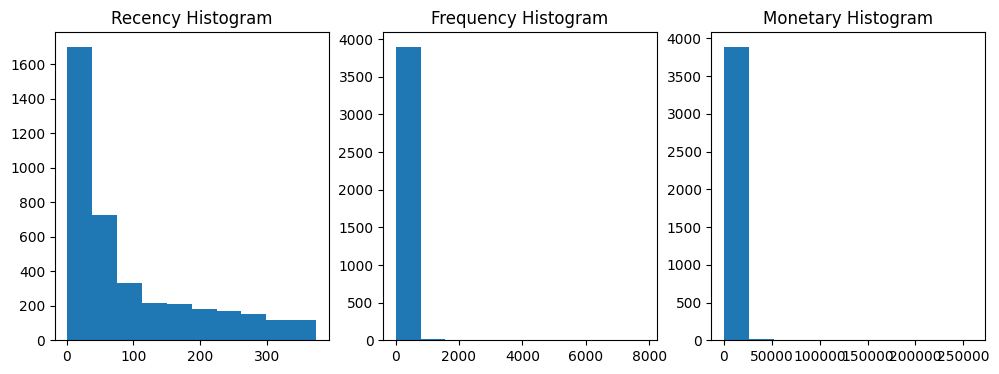

In [37]:
fig, (ax1, ax2, ax3) = plt.subplots(figsize=(12,4), nrows=1, ncols=3)
ax1.set_title('Recency Histogram')
ax1.hist(cust_df['Recency'])

ax2.set_title('Frequency Histogram')
ax2.hist(cust_df['Frequency'])

ax3.set_title('Monetary Histogram')
ax3.hist(cust_df['Monetary'])
plt.show()

In [38]:
cust_df[['Recency', 'Frequency', 'Monetary']].describe()

,Recency,Frequency,Monetary
count,3920.000000,3920.000000,3920.000000
mean,92.742092,90.388010,1864.385601
std,99.533485,217.808385,7482.817477
min,1.000000,1.000000,3.750000
25%,18.000000,17.000000,300.280000
50%,51.000000,41.000000,652.280000
75%,143.000000,99.250000,1576.585000
max,374.000000,7847.000000,259657.300000


상위 몇 개의 값으로 인해 매우 왜곡된 분포가 나타나는 것을 확인할 수 있다.

이처럼 왜곡 정도가 매우 높은 데이터 세트에 K-평균 군집을 적용하면 중심의 개수를 증가시키더라도 변별력이 떨어지는 군집화가 수행된다. 먼저 데이터 세트를 StandardScaler로 평균과 표준편차를 재조정한 뒤에 K-평균을 수행해보자.

In [39]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples

X_features = cust_df[['Recency', 'Frequency', 'Monetary']].values
X_features_scaled = StandardScaler().fit_transform(X_features)

kmeans = KMeans(n_clusters=3, random_state=0)
labels = kmeans.fit_predict(X_features_scaled)
cust_df['cluster_label'] = labels

print('Silhouette Score: {:.3f}'.format(silhouette_score(X_features_scaled, labels)))

Silhouette Score: 0.576


군집을 3개로 구성할 경우 전체 군집의 평균 실루엣 계수인 실루엣 스코어는 안정적인 수치가 나왔다.

In [40]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

def visualize_silhouette(cluster_list, X):
    from matplotlib import pyplot as plt

    for n_clusters in cluster_list:
        fig, ax1 = plt.subplots(1)
        fig.set_size_inches(6, 4)

        ax1.set_xlim([-0.1, 1])
        ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

        kmeans = KMeans(n_clusters=n_clusters, random_state=10)
        cluster_labels = kmeans.fit_predict(X)

        silhouette_vals = silhouette_samples(X, cluster_labels)
        silhouette_avg = silhouette_score(X, cluster_labels)

        y_lower = 10
        for i in range(n_clusters):
            ith_silhouette_vals = silhouette_vals[cluster_labels == i]
            ith_silhouette_vals.sort()

            size_cluster_i = ith_silhouette_vals.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.nipy_spectral(float(i) / n_clusters)
            ax1.fill_betweenx(np.arange(y_lower, y_upper),
                              0, ith_silhouette_vals,
                              facecolor=color, edgecolor=color, alpha=0.7)

            ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
            y_lower = y_upper + 10

        ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
        ax1.set_title(f"Silhouette plot for {n_clusters} clusters")
        ax1.set_xlabel("Silhouette coefficient values")
        ax1.set_ylabel("Cluster label")

        plt.tight_layout()
        plt.show()

In [41]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import seaborn as sns
import numpy as np

def visualize_kmeans_plot_multi(cluster_list, X_features):
    n_cols = len(cluster_list)
    fig, axes = plt.subplots(figsize=(5 * n_cols, 4), nrows=1, ncols=n_cols)

    for i, n_cluster in enumerate(cluster_list):
        clusterer = KMeans(n_clusters=n_cluster, random_state=0)
        cluster_labels = clusterer.fit_predict(X_features)

        # 시각화
        ax = axes[i]
        sns.scatterplot(x=X_features[:, 0], y=X_features[:, 1],
                        hue=cluster_labels, palette='Set2', ax=ax, legend=False)
        ax.set_title(f'KMeans Clustering: {n_cluster} clusters')
        ax.set_xlabel('Feature 1')
        ax.set_ylabel('Feature 2')

    plt.tight_layout()
    plt.show()

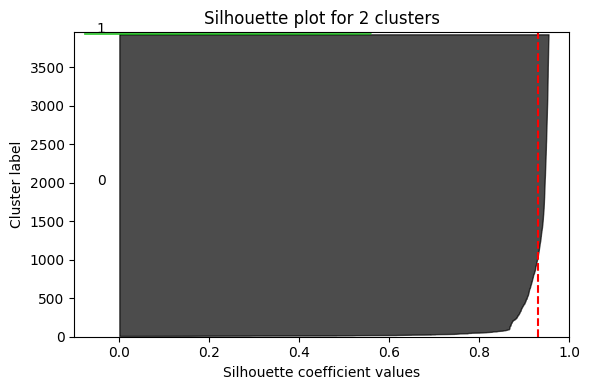

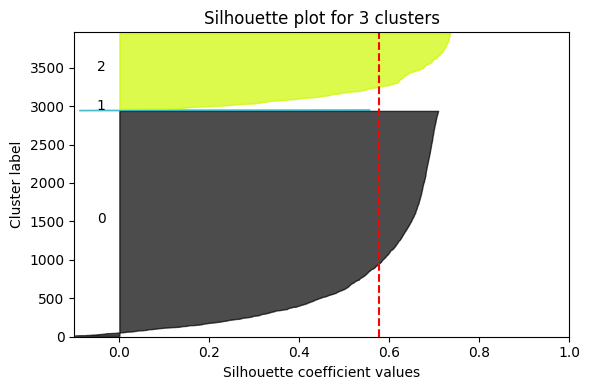

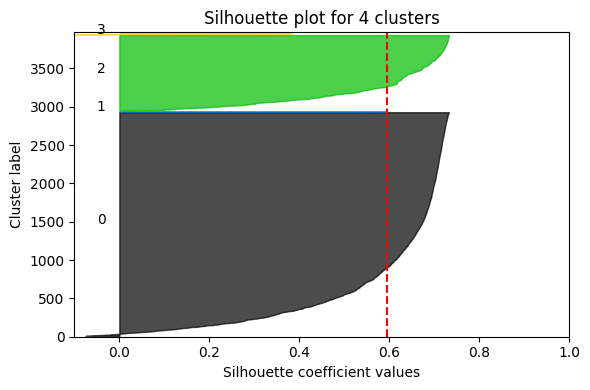

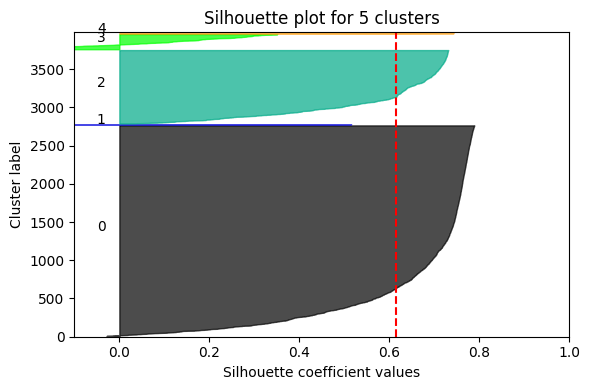

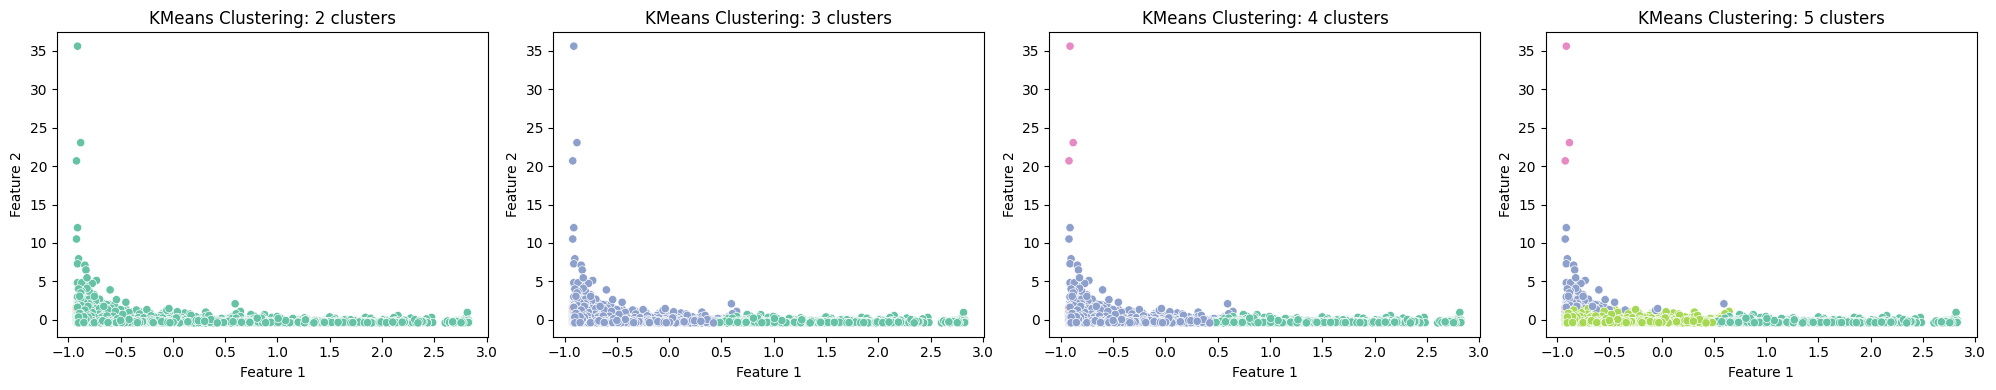

In [43]:
visualize_silhouette([2,3,4,5], X_features_scaled)
visualize_kmeans_plot_multi([2,3,4,5], X_features_scaled)

하지만 군집이 3개 이상일 때는 데이터 세트의 개수가 너무 작은 군집이 만들어진다. 또한 군집 내부에서도 데이터가 광범위하게 퍼져 있다. 이 소수의 데이터는 왜곡된 데이터 값인 특정 소매점의 대량 주문 구매 데이터이다.

이러한 특이한 데이터 세트를 분리하고 도출하는 것이 군집화의 목표이기도 하다. 하지만 이 정도로 크게 왜곡된 데이터 세트의 도출은 간단한 데이터 분석만으로도 충분히 가능하다.

군집화의 기능적 의미는 숨어있는 새로운 집단을 발견하는 것이다.

데이터 세트의 왜곡 정도를 낮추기 위해 가장 자주 사용되는 방법은 데이터 값에 로그(Log)를 적용하는 로그 변환이다.

In [44]:
from re import L
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples

cust_df['Recency_log'] = np.log1p(cust_df['Recency'])
cust_df['Frequency_log'] = np.log1p(cust_df['Frequency'])
cust_df['Monetary_log'] = np.log1p(cust_df['Monetary'])

X_features = cust_df[['Recency_log', 'Frequency_log', 'Monetary_log']].values
X_features_scaled = StandardScaler().fit_transform(X_features)

kmeans = KMeans(n_clusters=3, random_state=0)
labels = kmeans.fit_predict(X_features_scaled)
cust_df['cluster_label'] = labels

print('silhouette: {0:.3f}'.format(silhouette_score(X_features_scaled, labels)))

silhouette: 0.303


실루엣 스코어는 로그 변환하기 전보다 떨어진다. 하지만 실루엣 스코어의 절대치가 중요한 것이 아니라 개별 군집이 더 균일하게 나뉠 수 있는지가 더 중요하다.

## **정리**

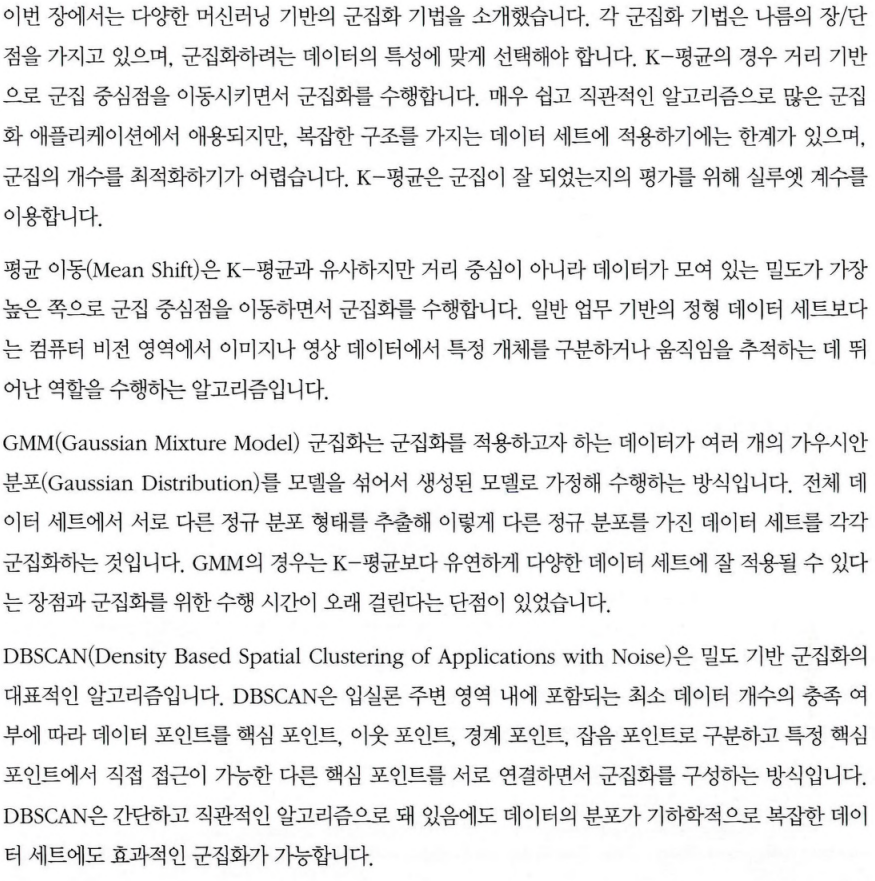